# Comparing axis-aligned random forest versus oblique forest on simulation datasets
The previous notebook conducted visual analysis using `Iris` dataset. Here we extend our analysis using custom simulation dataset: `sparse_parity`, from which OF demonstrates significant performance improvement over RF. Additionally, we prepared two toy datasets from scikit-learn dataset module, `make_hastie_10_2` and `make_gaussain_quantiles`, that also simulates high-dimentionality problems. OF also outperforms RF on these datasets but in lesser degree.

### Environment
- Python 3.8.13
- [Sklearn-Adam's dev branch](https://github.com/neurodata/scikit-learn/tree/obliquepr)

In [1]:
!python --version

Python 3.8.13


### Import packages

In [2]:
import sklearn
from sklearn.ensemble import RandomForestClassifier, ObliqueRandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_hastie_10_2, make_gaussian_quantiles #imported in case of testing
from sklearn.model_selection import RepeatedKFold, cross_validate

from datetime import datetime
from tqdm import tqdm
import itertools
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

random_state = 123456

sklearn.__version__

'1.2.dev0'

In [3]:
today = str(datetime.now().date())
today

'2022-06-15'

### Generating sparse parity simulation data
Sparse parity is a variation of the noisy parity problem, which itself is a multivariate generalization of the noisy XOR problem. This is a binary classification task in high dimensions. The simulation will generate uniformly distributed `n_samples` number of sample points in the range of -1 and +1 with `p` number of features. `p*` is a parameter used to limit features that carry information about the class. The informative binary label is then defined as 1 if there are odd number of the sum of data `X` across first `p*` features that are greater than 0, otherwise the label is defined as 0. The simulation is further detailed in our [publication](https://epubs.siam.org/doi/epdf/10.1137/1.9781611974973.56).

In [4]:
def sparse_parity(n_samples, p=20, p_star=3, random_seed=None, **kwarg):
 
    if random_seed: 
        np.random.seed(random_seed)

    X = np.random.uniform(-1, 1, (n_samples, p))
    y = np.zeros(n_samples)

    for i in range(0, n_samples):
        y[i] = sum(X[i, :p_star] > 0) % 2;

    return X, y

In [5]:
def get_sample(func, n, m=None, o=None):
    k = {}

    np.random.seed(random_state)

    if m: k['noise'] = m
    if o: k['n_features'] = o

    k['n_samples'] = n
    k['random_state'] = random_state # random_state for classifiers

    X, y = func(**k)

    return X, y

def get_scores(X, y, max_features, max_depth, random_state, n_cv, n_repeats):

    clfs = [
        RandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state),
        ObliqueRandomForestClassifier(max_features=max_features, max_depth=max_depth, random_state=random_state)
    ]

    tmp = []

    for i, clf in enumerate(clfs):

        # if i == 0 and isinstance(max_features, int):
            # if max_features > X.shape[1]:
            #     tmp.append(np.zeros(n_cv * n_repeats))
            #     continue

        cv = RepeatedKFold(n_splits=n_cv, n_repeats=n_repeats, random_state=random_state)
        test_score = cross_validate(estimator=clf, X=X, y=y, cv=cv, scoring='accuracy')
        
        tmp.append(
            test_score['test_score']
        )

    # print(f'max_feature: {max_features} | max_depth: {max_depth}')

    return tmp

In [6]:
X1,y1 = sparse_parity(n_samples=500,p=2,p_star=2)
X2,y2 = sparse_parity(n_samples=5000,p=3,p_star=3)
X1.shape, y1.shape, X2.shape, y2.shape

((500, 2), (500,), (5000, 3), (5000,))

### Visualization of sparse parity at low dimension
At `p=2`, sparse partiy becomes noisy XOR problem (left). Adding one more dimension makes the 3D XOR problem (right).

Text(0.5, 0.92, 'Sparse Parity at p=3')

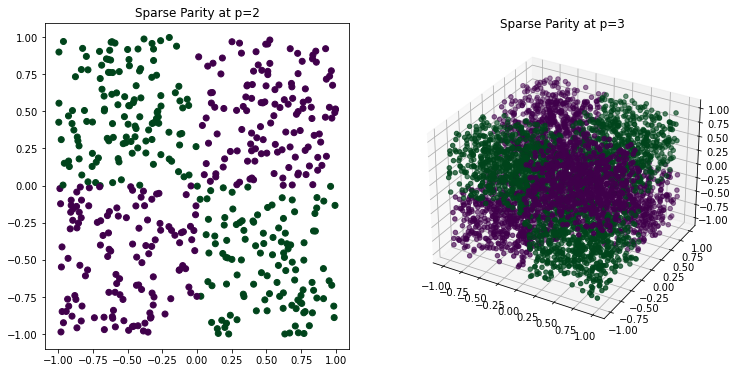

In [7]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(X1[:,0],X1[:,1], c=y1, cmap='PRGn')
ax.set_title('Sparse Parity at p=2')

ax = fig.add_subplot(122, projection='3d')
ax.scatter(X2[:,0],X2[:,1],X2[:,2], c=y2, cmap='PRGn')
ax.set_title('Sparse Parity at p=3')

In [8]:
def run_experiment(n_repeat, n_cv, random_state):
    n_samples = [100, 1000, 10000]
    accs = []
    
    clf_kwarg = {
        'max_features': None,
        'max_depth': 10,
        'random_state': random_state,
        'n_repeats': n_repeat,
        'n_cv': n_cv
    }

    for n_sample in tqdm(n_samples):
        data_args = [
            # name of dataset, function, n_sample, noise, n_features
            ['sparse_parity', sparse_parity, n_sample],

            #sklearn toy datasets can also be test by decommenting these lines
            # ['make_gaussian_quantiles', make_gaussian_quantiles, n_sample, None, 5], 
            # ['make_hastie_10_2', make_hastie_10_2, n_sample]
        ]

        for arg in data_args:
            X, y = get_sample(*arg[1:])
            
            for max_feature in ['sqrt', X.shape[1], X.shape[1]*2]: #max_features
                clf_kwarg['max_features'] = max_feature

                acc = get_scores(X, y, **clf_kwarg)
                accs.append([arg[0], n_sample, n_repeat, max_feature, clf_kwarg['max_depth'], random_state] + acc)

    df = pd.DataFrame(accs, columns=['dataset', 'n_sample', 'n_repeat', 'max_feature', 'max_depth', 'random_state', 'RF', 'OF'])
    df['delta'] = df.apply(lambda x: x.OF-x.RF, axis=1)

    # with open('dat/simulation_notebook_rf_vs_of.pkl', 'wb') as f:
    #     pickle.dump(df, f, protocol=pickle.HIGHEST_PROTOCOL)

    return df

In [9]:
df = run_experiment(n_repeat=1, n_cv=3, random_state=random_state)

100%|██████████| 3/3 [01:26<00:00, 28.81s/it]


In [10]:
df2 = df.copy()
df2['max_depth'] = df2.max_depth.replace(np.nan, 'inf')
df2 = df2.explode(['RF','OF','delta'])[['dataset','n_sample','max_feature','max_depth','RF','OF','delta']]
df2.head()

,dataset,n_sample,max_feature,max_depth,RF,OF,delta
0,sparse_parity,100,sqrt,10,0.441176,0.411765,-0.029412
0,sparse_parity,100,sqrt,10,0.363636,0.424242,0.060606
0,sparse_parity,100,sqrt,10,0.333333,0.424242,0.090909
1,sparse_parity,100,20,10,0.323529,0.294118,-0.029412
1,sparse_parity,100,20,10,0.424242,0.363636,-0.060606


In [11]:
dset = df2.dataset.unique()
max_depth = 10

# for i, d in enumerate(dset):
#     df_new = df2.query(f'dataset == "{d}" and max_depth == {max_depth}')
#     n_feature = df_new[~(df_new.max_feature == 'sqrt')].max_feature.min() #minimum numeric max_feature

#     df_mf1 = df_new.query(f'max_feature == {n_feature}') #RF max_feature to be compared with OF 2x, 3x max_feature

#     for ns in df_mf1.n_sample.unique(): #n_sample
#         for mf_not_1 in df_new.max_feature.unique():
#             if mf_not_1 in [n_feature, 'sqrt']:
#                 continue

#             indexing = (df2.dataset==d) & (df2.max_depth==max_depth) & (df2.n_sample==ns) & (df2.max_feature==mf_not_1)
#             df2.loc[indexing, ['RF']] = df_mf1.query(f'n_sample == {ns}').RF.tolist()

df2['delta'] = df2.apply(lambda x: x.OF-x.RF, axis=1)

In [12]:
df2.head()

,dataset,n_sample,max_feature,max_depth,RF,OF,delta
0,sparse_parity,100,sqrt,10,0.441176,0.411765,-0.029412
0,sparse_parity,100,sqrt,10,0.363636,0.424242,0.060606
0,sparse_parity,100,sqrt,10,0.333333,0.424242,0.090909
1,sparse_parity,100,20,10,0.323529,0.294118,-0.029412
1,sparse_parity,100,20,10,0.424242,0.363636,-0.060606


### Base Model Result
Three settings of the `max_features` are compared and their corresponding delta accuracy between OF and RF is shown as a bar plot. After a meaningful number of data is simulated (i.e., `n_samples` > 10^4), OF starts to outperform RF significantly across all `max_features` settings especially when `max_feature` is greater than or equal to `n_features`.

The most likely reason for this is because OF should be more robust to high-dimensional noise. Moreover, due to the ability to sample more variable splits (i.e. `max_features` can be greater than `n_features` compared to RF), then we expect to see an increase in performance when we are willing to use computational power to sample more splits.

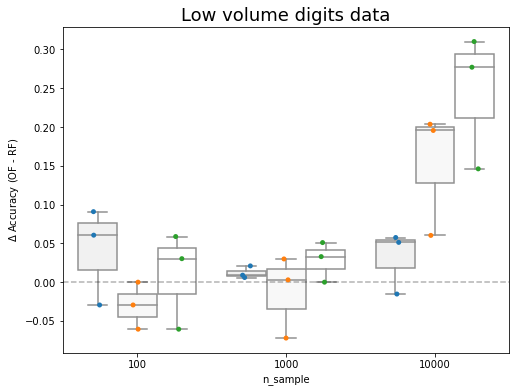

In [133]:
dset = df2.dataset.unique() #get the list of dataset loaded

ncols = 1

fig, ax = plt.subplots(figsize=(8,6))

sns.stripplot(data=df_new, x='n_sample', y='delta', hue='max_feature', ax=ax, dodge=True)
sns.boxplot(data=df_new, x='n_sample', y='delta', ax=ax, hue='max_feature', color='white')

ax.set_ylabel(r'$\Delta$ Accuracy (OF - RF)')
ax.set_title('Low volume digits data', fontsize=18);
ax.axhline(y=0, ls='--', color='black', alpha=0.3);
ax.legend([],[], frameon=False);

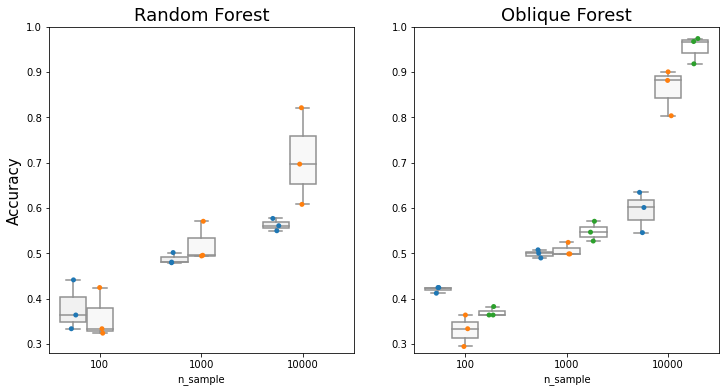

In [138]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

df_new2 = df_new.copy()
df_new2.loc[df_new2.max_feature==40,'RF'] = 2 #remove 2x mtry from RF

for i, j in enumerate(['RF', 'OF']):
    g = sns.boxplot(data=df_new2, x='n_sample', y=j, ax=ax[i], hue='max_feature', color='white')
    h = sns.stripplot(data=df_new2, x='n_sample', y=j, ax=ax[i], hue='max_feature', dodge=True)

ax[0].set_ylabel(r'Accuracy', fontsize=15)
ax[1].set_ylabel('', fontsize=15)
ax[0].set_title('Random Forest', fontsize=18);
ax[1].set_title('Oblique Forest', fontsize=18);

for nc in range(2):
    ax[nc].set_ylim(0.28,1.0)
    ax[nc].legend([],[], frameon=False) #temp legend fix to remove double legends

### Optimized Model Comparison via Grid Searching
The following is the optimized result from grid searching best paramters of three features: `max_features`, `n_estimators`, `max_depth`

In [22]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'max_features': ['sqrt', 'log2', None, 40],
    'n_estimators': [i for i in range(100,1000,100)],
    'max_depth': [5,10,15,20,None]
}

df_cv = pd.DataFrame()

feat_cols = list(params.keys())+['mean_test_score','clf']

clfs = [
    RandomForestClassifier(random_state=random_state),
    ObliqueRandomForestClassifier(random_state=random_state)
]

X, y = get_sample(sparse_parity, 10000)

for clf, clf_lab in zip(clfs, ['RF', 'OF']):
    search = RandomizedSearchCV(estimator=clf, param_distributions=params, n_iter=20, random_state=random_state)
    search.fit(X, y)

    df_tmp = pd.DataFrame(search.cv_results_)
    df_tmp.columns = [i.replace('param_','') for i in df_tmp.columns]
    df_tmp['clf'] = clf_lab
    df_tmp.fillna('None', inplace=True)
    df_tmp['mean_test_score'] = df_tmp.apply(lambda x: round(x['mean_test_score'], 3), axis=1)
    df_cv = pd.concat([df_cv, df_tmp])

In [23]:
df_cv_rf = df_cv[feat_cols].query('clf == "RF"').sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
df_cv_rf.head()

,max_features,n_estimators,max_depth,mean_test_score,clf
0,40,700,None,0.898,RF
1,40,200,None,0.879,RF
2,40,900,15,0.872,RF
3,40,700,15,0.864,RF
4,None,100,15,0.835,RF


In [24]:
df_cv_of = df_cv[feat_cols].query('clf == "OF"').sort_values(by='mean_test_score', ascending=False).reset_index(drop=True)
df_cv_of.head()

,max_features,n_estimators,max_depth,mean_test_score,clf
0,40,900,15,0.997,OF
1,40,700,None,0.997,OF
2,40,700,15,0.997,OF
3,40,200,None,0.995,OF
4,None,100,15,0.946,OF


### Visualization of parameterized grid search result

In [25]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+notebook_connected"

fig = px.parallel_categories(
    df_cv_rf.iloc[:,:-1],
    color='mean_test_score'
)
fig.show()

In [26]:
px.parallel_categories(
    df_cv_of.iloc[:,:-1],
    color='mean_test_score'
)

### Appendix
The actual values used to generate the above plots

In [19]:
col_groupby = ['dataset','n_sample','max_feature','max_depth']
dff = df2.groupby(col_groupby).mean()
dff.style.background_gradient(cmap='RdBu_r', vmin=-0.4, vmax=0.4)

In [139]:
df_cv.query('clf == "RF"')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,n_estimators,max_features,max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,clf
0,9.824490,0.160347,0.367614,0.006759,400,sqrt,20,"{'n_estimators': 400, 'max_features': 'sqrt', ...",0.7440,0.7610,0.7535,0.6925,0.6935,0.729,0.029805,7,RF
1,10.979304,0.174483,0.418130,0.006136,400,sqrt,None,"{'n_estimators': 400, 'max_features': 'sqrt', ...",0.7660,0.8020,0.7600,0.7200,0.7010,0.750,0.035667,6,RF
2,85.888052,0.894214,0.684722,0.016078,900,40,15,"{'n_estimators': 900, 'max_features': 40, 'max...",0.8915,0.9385,0.9015,0.8030,0.8255,0.872,0.050192,3,RF
3,2.729691,0.053969,0.105233,0.002907,100,log2,None,"{'n_estimators': 100, 'max_features': 'log2', ...",0.7300,0.7690,0.7385,0.6975,0.6690,0.721,0.034489,10,RF
4,19.861284,0.265788,0.735325,0.007114,800,sqrt,20,"{'n_estimators': 800, 'max_features': 'sqrt', ...",0.7555,0.7600,0.7665,0.6710,0.6865,0.728,0.040580,8,RF
5,3.972871,0.014544,0.033921,0.000671,100,40,5,"{'n_estimators': 100, 'max_features': 40, 'max...",0.5015,0.5415,0.8230,0.5155,0.5070,0.578,0.123415,17,RF
6,0.900659,0.004660,0.032919,0.000578,100,log2,5,"{'n_estimators': 100, 'max_features': 'log2', ...",0.5155,0.5035,0.5505,0.4950,0.5255,0.518,0.019277,19,RF
7,10.611544,0.120495,0.388585,0.003641,500,sqrt,15,"{'n_estimators': 500, 'max_features': 'sqrt', ...",0.6940,0.7030,0.7165,0.6310,0.6335,0.676,0.036121,11,RF
8,9.407937,0.119426,0.075254,0.001648,100,None,15,"{'n_estimators': 100, 'max_features': None, 'm...",0.8850,0.8880,0.8885,0.7865,0.7280,0.835,0.066291,5,RF
9,4.210815,0.039711,0.155348,0.001597,200,log2,15,"{'n_estimators': 200, 'max_features': 'log2', ...",0.6670,0.6565,0.7305,0.6250,0.6065,0.657,0.042607,15,RF


In [140]:
df_cv.query('clf == "OF"')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,n_estimators,max_features,max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,clf
0,7.365442,0.048932,0.378005,0.003749,400,sqrt,20,"{'n_estimators': 400, 'max_features': 'sqrt', ...",0.7415,0.7565,0.7250,0.6990,0.7255,0.730,0.019181,11,OF
1,8.114648,0.290865,0.416607,0.013279,400,sqrt,None,"{'n_estimators': 400, 'max_features': 'sqrt', ...",0.7455,0.7330,0.7580,0.7190,0.7285,0.737,0.013604,10,OF
2,106.408613,1.582755,0.653689,0.039327,900,40,15,"{'n_estimators': 900, 'max_features': 40, 'max...",0.9980,0.9980,0.9975,0.9945,0.9965,0.997,0.001319,2,OF
3,2.030143,0.022744,0.105387,0.000656,100,log2,None,"{'n_estimators': 100, 'max_features': 'log2', ...",0.6860,0.6850,0.7105,0.6795,0.6940,0.691,0.010794,16,OF
4,14.752315,0.316534,0.761073,0.029957,800,sqrt,20,"{'n_estimators': 800, 'max_features': 'sqrt', ...",0.7410,0.7675,0.7415,0.7425,0.7500,0.749,0.010045,8,OF
5,4.987083,0.062359,0.034643,0.001479,100,40,5,"{'n_estimators': 100, 'max_features': 40, 'max...",0.7315,0.8925,0.8000,0.7115,0.7040,0.768,0.070915,7,OF
6,0.638029,0.005643,0.034610,0.001112,100,log2,5,"{'n_estimators': 100, 'max_features': 'log2', ...",0.5230,0.5395,0.5240,0.5370,0.5150,0.528,0.009196,20,OF
7,7.963491,0.207075,0.436764,0.035282,500,sqrt,15,"{'n_estimators': 500, 'max_features': 'sqrt', ...",0.6910,0.7230,0.6905,0.7050,0.7005,0.702,0.011879,15,OF
8,6.369174,0.029361,0.076234,0.000538,100,None,15,"{'n_estimators': 100, 'max_features': None, 'm...",0.9480,0.9530,0.9605,0.9305,0.9385,0.946,0.010580,5,OF
9,3.070819,0.032555,0.159679,0.008374,200,log2,15,"{'n_estimators': 200, 'max_features': 'log2', ...",0.6620,0.7015,0.6740,0.6550,0.6725,0.673,0.015865,17,OF
